In [1]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output
from matplotlib import pyplot as plt

sys.path.append('../../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, lrna_price, dynamicadd_lrna_fee, dynamicadd_asset_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import price_manipulation, omnipool_arbitrage, price_manipulation_multiple_blocks
from model.amm.global_state import GlobalState, value_assets

In [2]:
# same seed, same parameters = same simulation result[[
random.seed(42)

assets = {
    'HDX': {'usd price': 0.005, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'DAI': {'usd price': 1, 'weight': 0.20},
    'ETH': {'usd price': 1000, 'weight': 0.20},
    'DOGE': {'usd price': 0.01, 'weight': 0.30}
    # 'shitcoin': {'usd price': 1, 'weight': 0.10},
}

lrna_price_usd = 22
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn], 'weight_cap': 1} for tkn in assets
            },
            # lrna_fee=dynamicadd_lrna_fee(
            #     minimum=0.0025, 
            #     amplification=0.9166666666666667, 
            #     decay=5e-06,
            #     fee_max=0.015625,
            #     raise_oracle_name='fee_raise',
            # ),
            # oracles={'fee_raise': 11},  # , 'fee_lower': 7200},
            # asset_fee=dynamicadd_asset_fee(
            #     minimum=0.0025,
            #     amplification=2, 
            #     decay=6.17283950617284e-06,
            #     fee_max=0.5,
            #     raise_oracle_name='fee_raise'
            # )
            asset_fee=0.0025,
            lrna_fee=0.0005,
            max_withdrawal_per_block = 0.05,
            remove_liquidity_volatility_threshold=0.01,
            # trade_limit_per_block=0.05
        )
    },
    agents={
        'Attacker': Agent(
            holdings={'USD': 5000000, 'DAI': 5000000, 'LRNA': 0},
            trade_strategy=price_manipulation_multiple_blocks(
                pool_id='omnipool',
            )
        ),
        'Arbitrageur': Agent(
            holdings={tkn: 100000000000 for tkn in list(assets.keys()) + ['LRNA']},
            trade_strategy=omnipool_arbitrage('omnipool')
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)

time_steps=7000
events = run.run(initial_state, time_steps=time_steps)
# add_arb_state = events[-1].copy()
# add_arb_state.agents['Attacker'].trade_strategy += omnipool_arbitrage('omnipool')
# events += run.run(add_arb_state, time_steps=time_steps)

Starting simulation...


C:\Users\jepid\PycharmProjects\HydraDX-simulations\hydradx\notebooks\Omnipool\vault\../../..\model\amm\omnipool_amm.py:331: RuntimeWarning: invalid value encountered in double_scalars
  delta_Qj = state.lrna[tkn_buy] * buy_quantity / (


Execution time: 53.217 seconds.


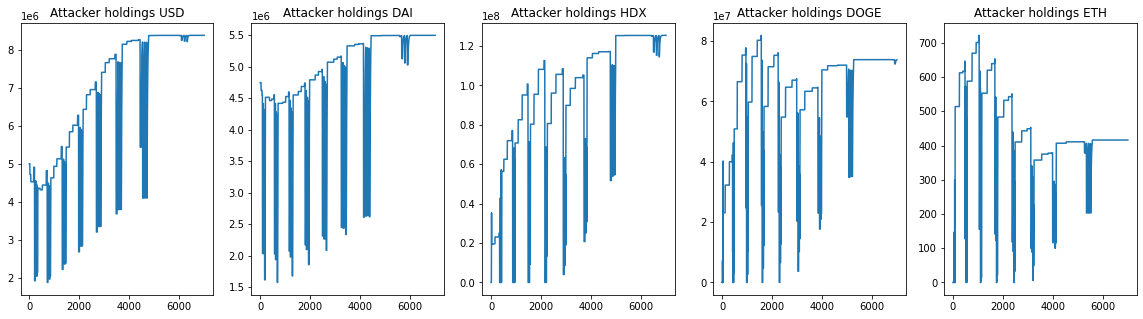

In [3]:
pu.plot(events, agent='Attacker', prop='holdings', key=['USD', 'DAI', 'HDX', 'DOGE', 'ETH'])


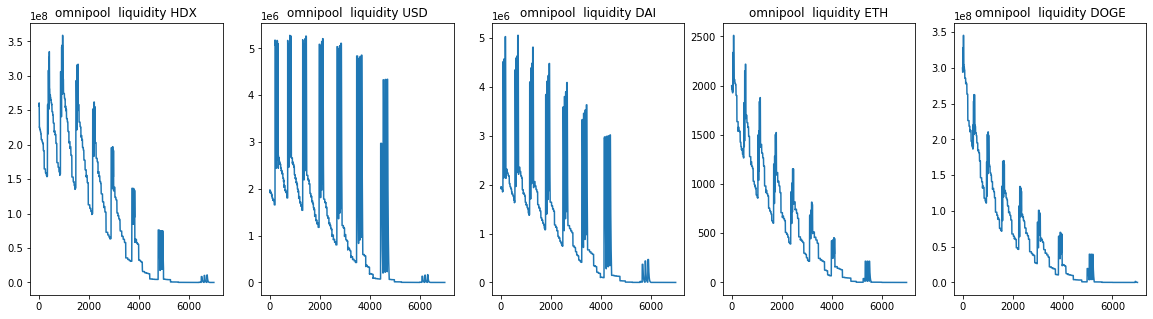

In [4]:
pu.plot(events, pool='omnipool', prop='liquidity')

In [5]:
loss_percent=(1 - events[-1].pool_val(events[-1].pools['omnipool']) / initial_state.pool_val(initial_state.pools['omnipool'])) * 100
print()
print(f'{loss_percent}% of the pool drained in {time_steps} blocks.')


99.9932902431479% of the pool drained in 7000 blocks.


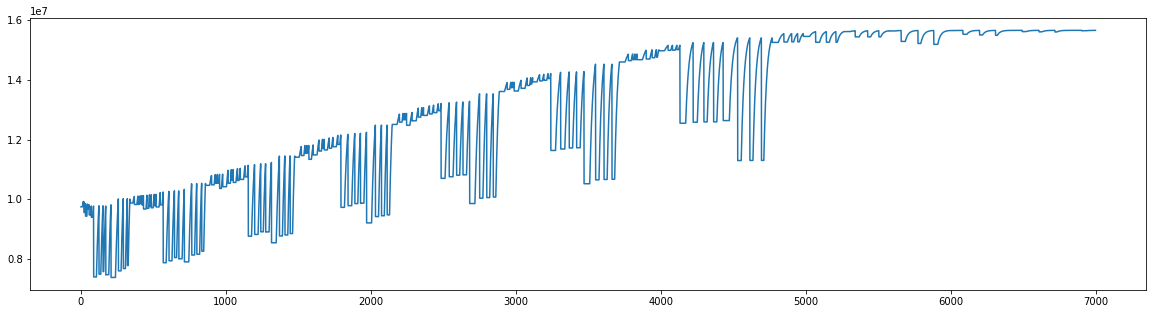

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), [value_assets(event.external_market, event.agents['Attacker'].holdings) for event in events])

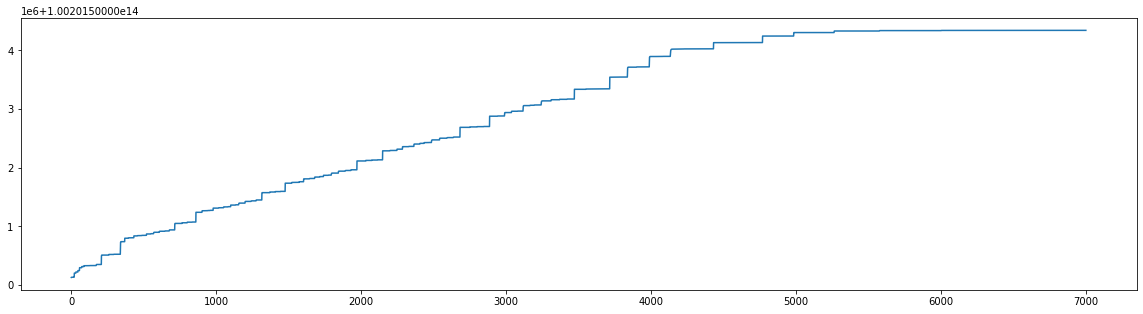

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), [value_assets(event.external_market, event.agents['Arbitrageur'].holdings) for event in events])

In [8]:
print(events[-1].agents['Attacker'])

Agent: Attacker
********************************
trade strategy: price manipulation
holdings: (

    *USD*: 8380666.897008504

    *DAI*: 5495184.178158395

    *LRNA*: 0.0

    *HDX*: 125344812.3580994

    *ETH*: 415.9885453694

    *DOGE*: 73780177.8575454

    *('omnipool', 'HDX')*: 0.0
    price: 193287047530528.3

    *('omnipool', 'DOGE')*: 140447669395559.86
    price: 1.283125332297313e+16

    *('omnipool', 'ETH')*: 0.0
    price: 1035472109645980.9

    *('omnipool', 'DAI')*: 0.0
    price: 30747330979677.848

    *('omnipool', 'USD')*: 0.0
    price: 1004996256108645.5
)



In [9]:
print(value_assets(initial_state.external_market, initial_state.agents['Attacker'].holdings))
print(value_assets(events[-1].external_market, events[-1].agents['Attacker'].holdings))

10000000.0
15656365.460902294
